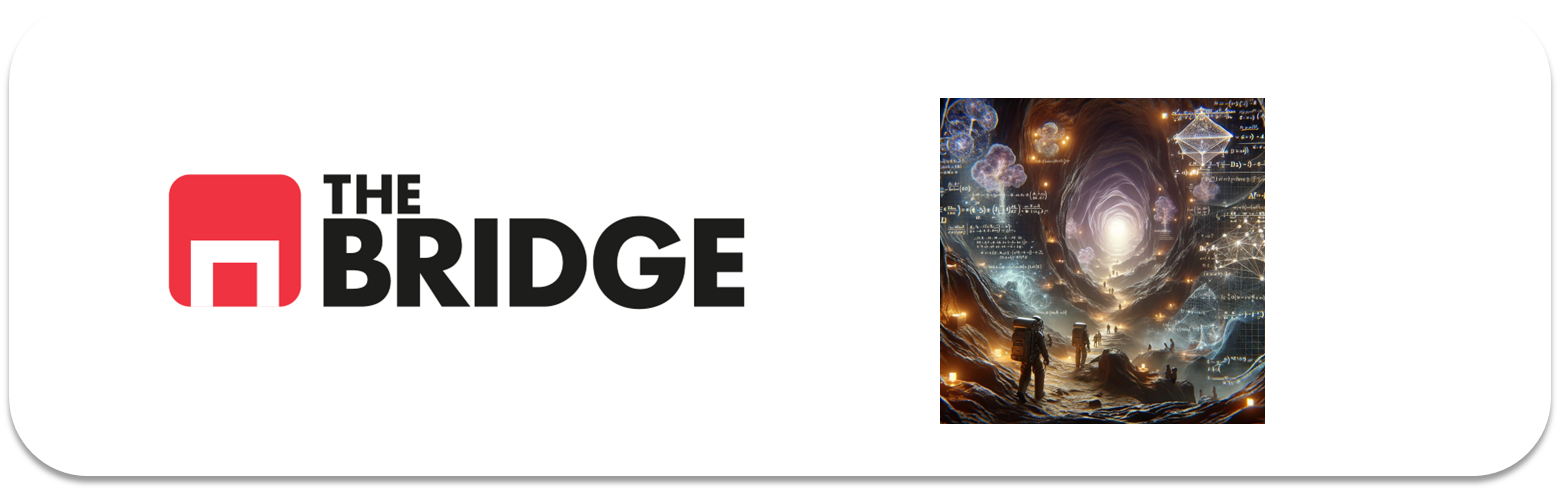

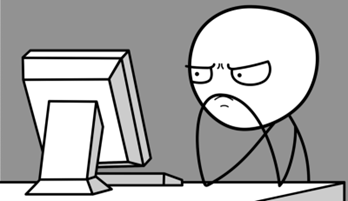

Para ejercitarte y afianzar lo aprendido sobre **Keras y DL**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Predecir eficiencia de gasolina

En este conjuntos de ejercicios vamos a trabajar sobre el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) para construir un modelo DL para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Para la construcción del modelo vamos a utilizar Keras.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import whole class and then access using fully qualified names
from keras._tf_keras import keras

# Pylance not working
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

from utils import datascience as ds

### Ejercicio 1

Carga los datos en un dataframe, utilizando como nombre de columnas los siguientes:

```python
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
``` 


*Nos han dado los datos en un fichero de texto, sobre el que no puedo hacer el típico read_csv. Tendremos que recordar el procesamiento de ficheros de texto para manipularlo y obtener el dataset*

In [2]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 
                'Weight', 'Acceleration', 'Model Year', 'Origin'
                ]

with open('./data/autos_data.txt') as f:
    data = f.read()

list_data = []

for line in data.split("\n"):
    # data = {key.lower(): value for key, value in zip(column_names, line.split"\t")[0].(split() + [line.split("\t")[-1].replace('"','')])}
    data = {key.lower(): value for key, value in zip(column_names, line.split())}
    list_data.append(data)

df_autos = pd.DataFrame(list_data)
df_autos

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.,12.0,70,1
1,15.0,8,350.0,165.0,3693.,11.5,70,1
2,18.0,8,318.0,150.0,3436.,11.0,70,1
3,16.0,8,304.0,150.0,3433.,12.0,70,1
4,17.0,8,302.0,140.0,3449.,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.,15.6,82,1
394,44.0,4,97.00,52.00,2130.,24.6,82,2
395,32.0,4,135.0,84.00,2295.,11.6,82,1
396,28.0,4,120.0,79.00,2625.,18.6,82,1


### Ejercicio 2: Limpieza inicial

Echa un primer vistazo. Limpia columnas "raras". Deshazte de nulos (cuidado aquí), arregla el tipo de las features numéricas si fuera necesario. Haz una lista de las features categóricas que tuvieramos que convertir posteriormente. (Es antes del split pero no importa para este ejercicio)

In [3]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mpg           398 non-null    object
 1   cylinders     398 non-null    object
 2   displacement  398 non-null    object
 3   horsepower    398 non-null    object
 4   weight        398 non-null    object
 5   acceleration  398 non-null    object
 6   model year    398 non-null    object
 7   origin        398 non-null    object
dtypes: object(8)
memory usage: 25.0+ KB


In [4]:
ds.get_cardinality(df_autos)

pandas.DataFrame shape:  (398, 8)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
mpg,129,32.41206,0,0.0,object,Numeric - Continuous
cylinders,5,1.256281,0,0.0,object,Categoric
displacement,82,20.603015,0,0.0,object,Numeric - Discrete
horsepower,94,23.61809,0,0.0,object,Numeric - Discrete
weight,351,88.190955,0,0.0,object,Numeric - Continuous
acceleration,96,24.120603,0,0.0,object,Numeric - Discrete
model year,13,3.266332,0,0.0,object,Numeric - Discrete
origin,3,0.753769,0,0.0,object,Categoric


*Weight claramente es una columna rara, la tenemos que limpiar*

In [5]:
df_autos["weight"] = df_autos["weight"].str.replace(".","").astype(int)

*Parece que no hay nulos y hay muchas que parecen numéricas que están clasificadas como `object`. No parece que haya categóricas que convertir porque origin esta codificada y cylinders también*

*Convirtamos todas a numéricas (pero veremos que va a fallar)*

In [6]:
# Esto fallará por los interrogantes "?"
df_autos = df_autos.astype("float") 

ValueError: could not convert string to float: '?'

In [7]:
# Los caballos de vapor tienen 6 valores missing
(df_autos == '?').sum() 

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [8]:
df_autos.loc[df_autos.horsepower == '?', 'horsepower']

32     ?
126    ?
330    ?
336    ?
354    ?
374    ?
Name: horsepower, dtype: object

*Vaya hay valores raros, quizás missings, con el interrogante, tenemos más trabajo del que esperábamos*

In [9]:
for col in df_autos.columns:
    # Convertir los "?" en nulo np.nan
    df_autos[col] = df_autos[col].apply(lambda row: row if str(row) != "?" else np.nan).astype("float")

df_autos['horsepower'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 398 entries, 0 to 397
Series name: horsepower
Non-Null Count  Dtype  
--------------  -----  
392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


*Tenemos 6 nulos en horsepower, que tiramos como nos dice el enunciado*

In [10]:
# Eliminar nulos
df_autos.dropna(inplace=True)

### Ejercicio 3

Antes de seguir nos informan que las etiquetas de "origin" correspoden a  USA para el 1, Europa para el 2 y Japón para el 3. Convierte origin a esos valores porque queremos tener el literal. Luego haz directamente un one-hot encoding de esas variable.  

*NOTA: Realmente los one-hot-encoding se pueden hacer contra el dataset original desde el principio (no afectan unos a otros), si nos los hacemos es porque hasta que no se han analizado las variables puede que no tengamos claro que queremos hacer si una codificación ordinal, una vectorización (onehot) o bien queremos hacer otro cambio en la variable y esos vienen dados por la relación de la categórica con el target y por tanto sólo se pueden ver en el train. Pero si por lo que sea sabemos seguros que vamos a hacer vectorización no hay problema en hacerlo antes del split. Por otro lado, siempre conviene quedarse con una categoria unkown para valores que pueden llegar en el futuro antes de un recalibrado.*


In [11]:
df_autos['origin'] = df_autos['origin'].map( {1.0: 'USA', 2.0: 'Europe', 3.0: 'Japan'})

df_autos['origin'].value_counts()

origin
USA       245
Japan      79
Europe     68
Name: count, dtype: int64

In [12]:
df_autos = pd.get_dummies(df_autos, columns=['origin'], dtype=int)
df_autos.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_Europe,origin_Japan,origin_USA
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,0,0,1
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,0,0,1
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,0,0,1
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,0,0,1
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,0,0,1


### Ejercicio 4

Divide los datos en train y test. Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo. Emplea una variable target para guardar el nombre de la columna target.

NOTA: El resultado tienen que ser dos datasets

*Es un problema de regresión así que no tiene sentido hacer un stratify.*

In [13]:
# Split
train_set, test_set = train_test_split(df_autos, train_size=0.8, random_state=42)

In [14]:
# Target
target = 'mpg'

### Ejercicio 5

Inspecciona los datos. Revisa rápidamente la distribución conjunta del dataset de entrenamiento mediante un grid de gráficos

*Empezamos viendo la distribución del target.*

<Axes: xlabel='mpg', ylabel='Count'>

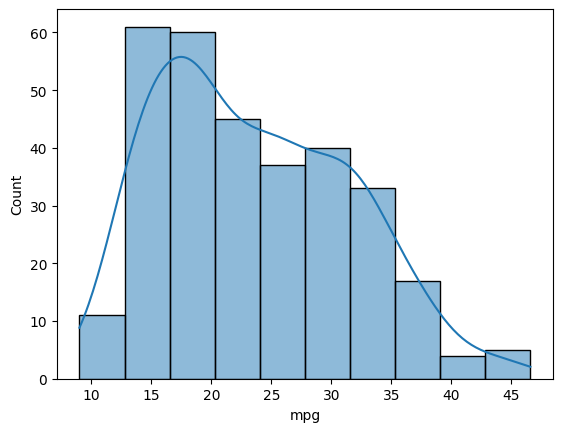

In [15]:
sns.histplot(data=train_set, x=target, kde=True)

*No es exactamente normal, pero no tienen mala "figura"*

*Veamos el resto con un pairplot, y aunque son pocas columnas son claramente muchas para el pairplot, así que lo hago por tramos.*

In [16]:
features = [col for col in train_set.columns if col != target]
len(features)

9

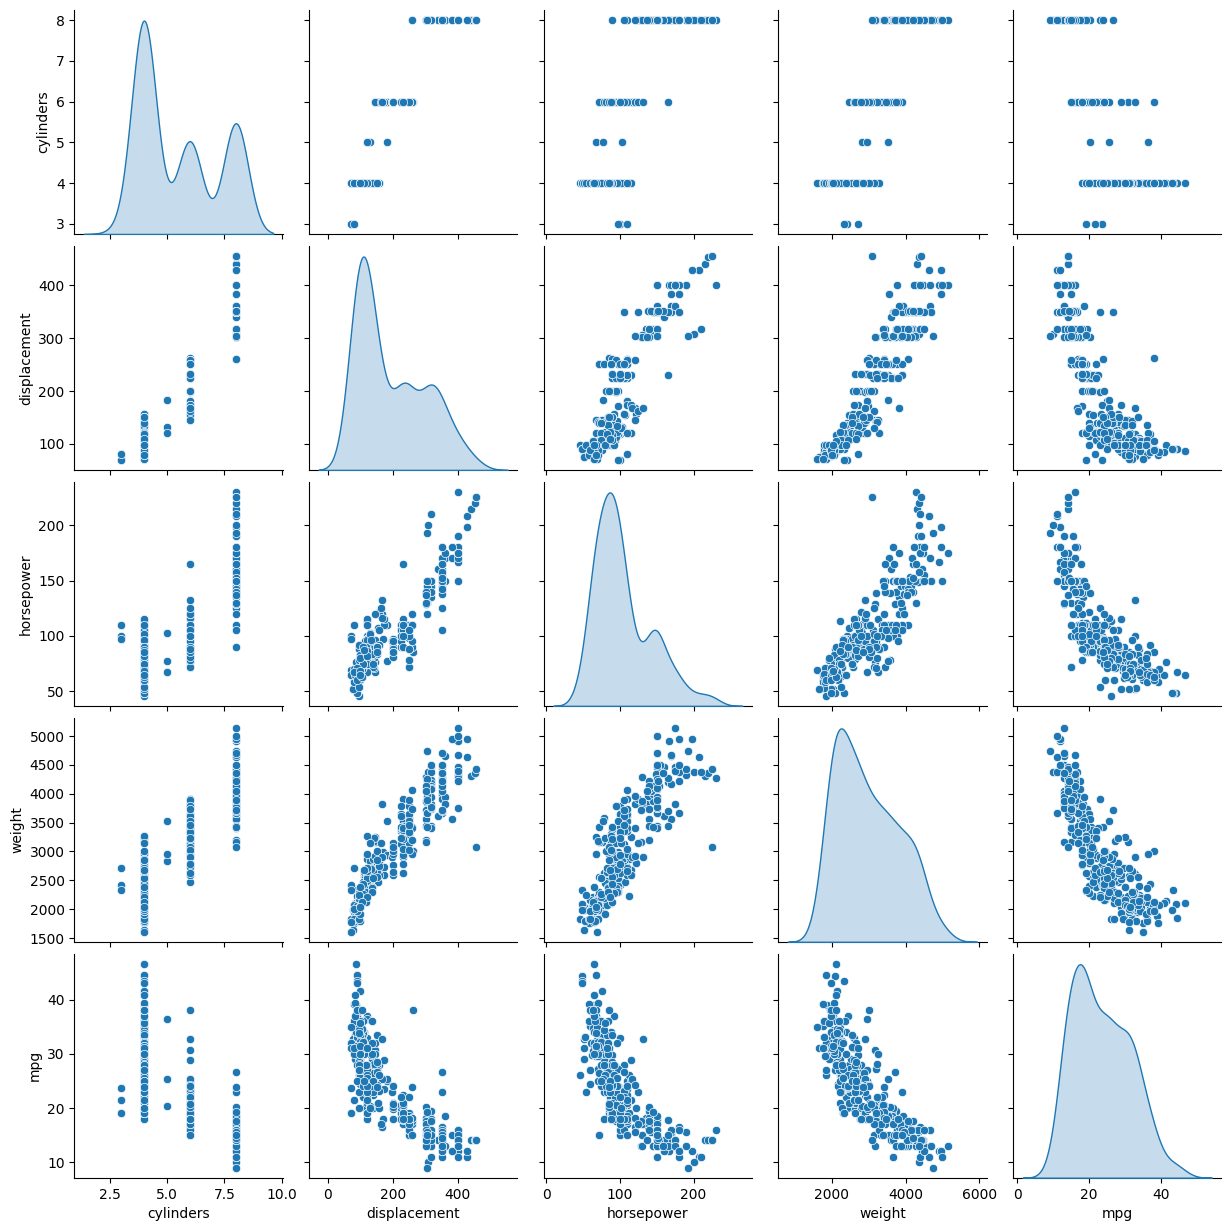

In [17]:
sns.pairplot(train_set[features[0:4]+[target]], diag_kind="kde");

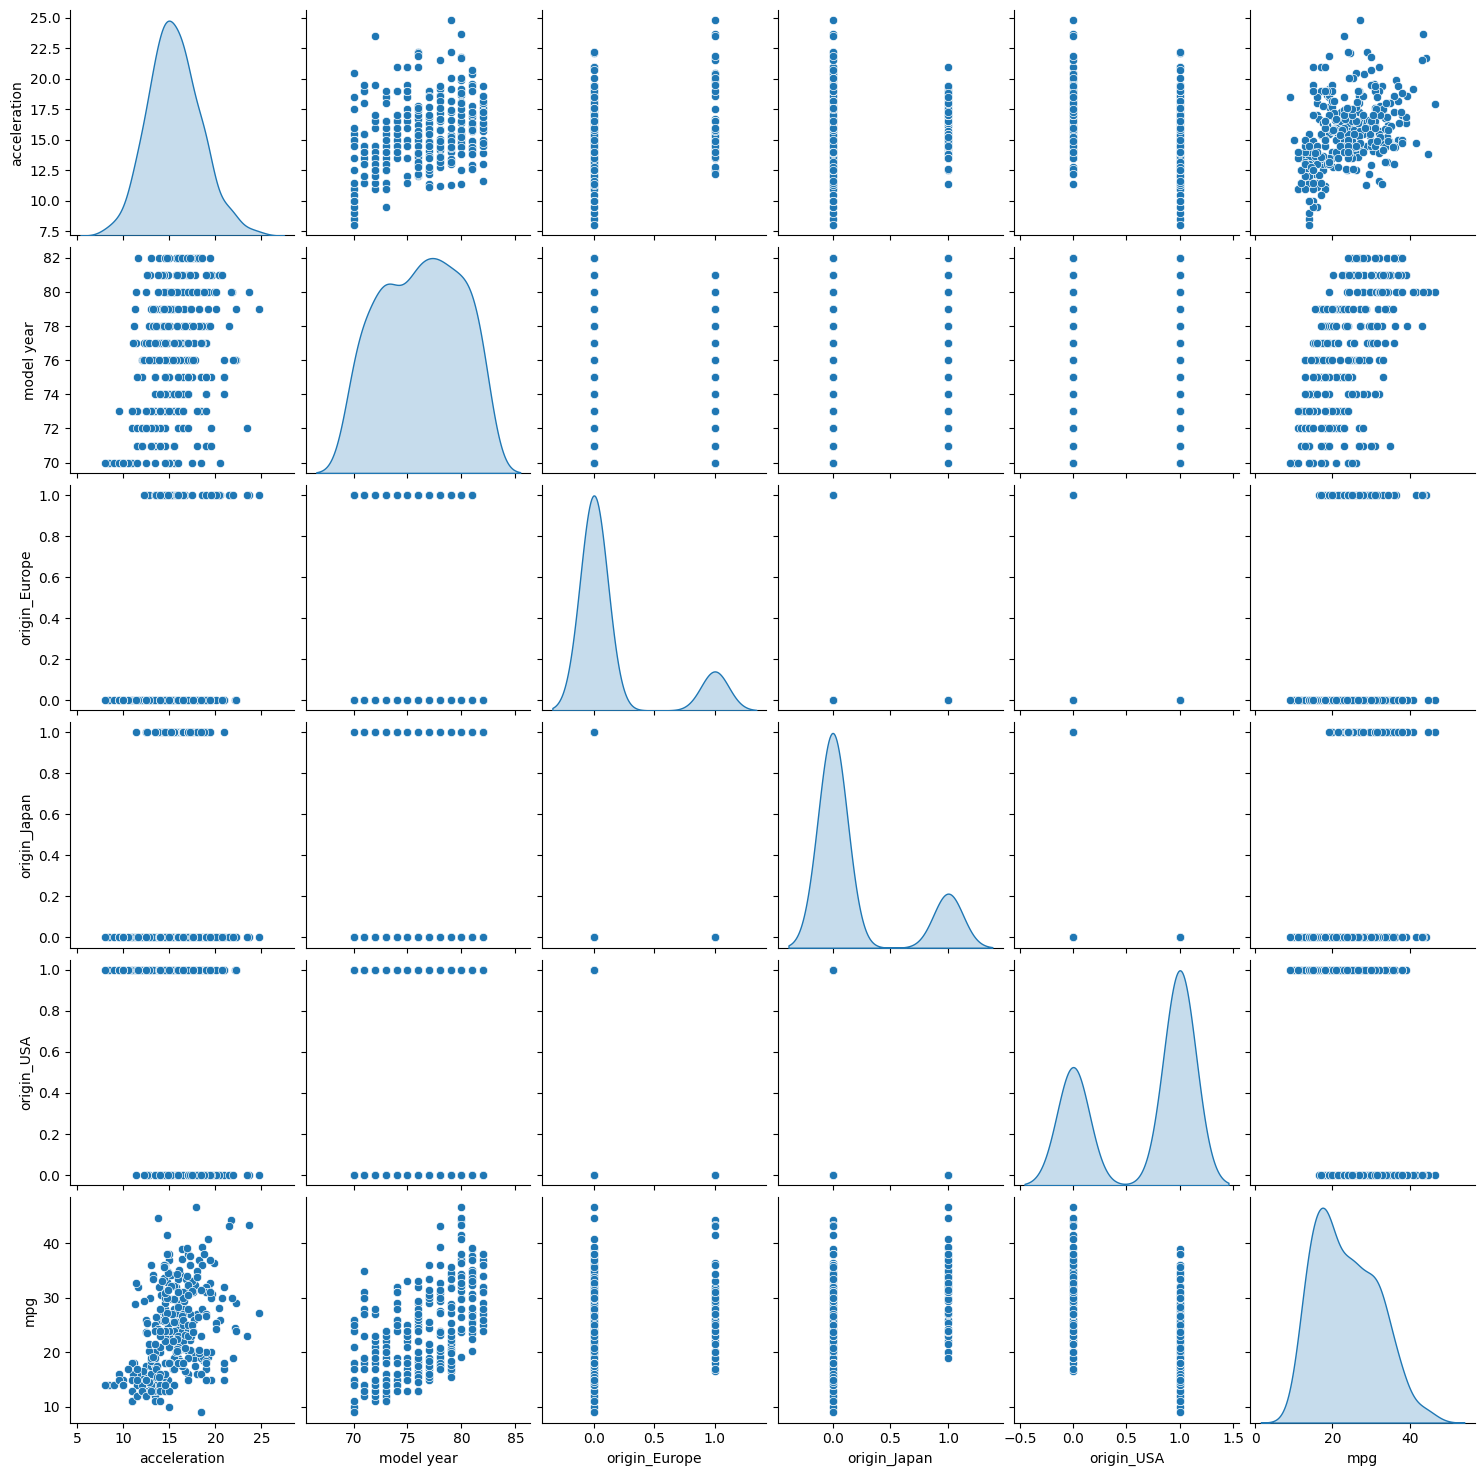

In [18]:
sns.pairplot(train_set[features[4:]+[target]], diag_kind="kde");

*Se ven claras correlaciones, algunas no lineales, entre varias de las vairables, deberíamos quizá ser selectivos a la hora de escoger que features priorizar para los modelos*

*Si quieres tú puedes hacerlo con tiempo, para el contexto de este ejercicio nos quedaremos con todas*

*Además en el contexto del DL pensaba que no debíamos invertir demasido tiempo en pelearnos con las features...*

*Hagamos también nuestro pequeño análisis de correlación **bivariante**:*

In [19]:
corr = train_set.corr()
np.abs(corr[target]).sort_values(ascending = False)

mpg              1.000000
weight           0.835568
displacement     0.811580
horsepower       0.782381
cylinders        0.780555
model year       0.590454
origin_USA       0.562162
origin_Japan     0.473004
acceleration     0.412048
origin_Europe    0.220038
Name: mpg, dtype: float64

*Son correlaciones bastante altas, esperamos que aporten y para completar podemos ver el heatmap*

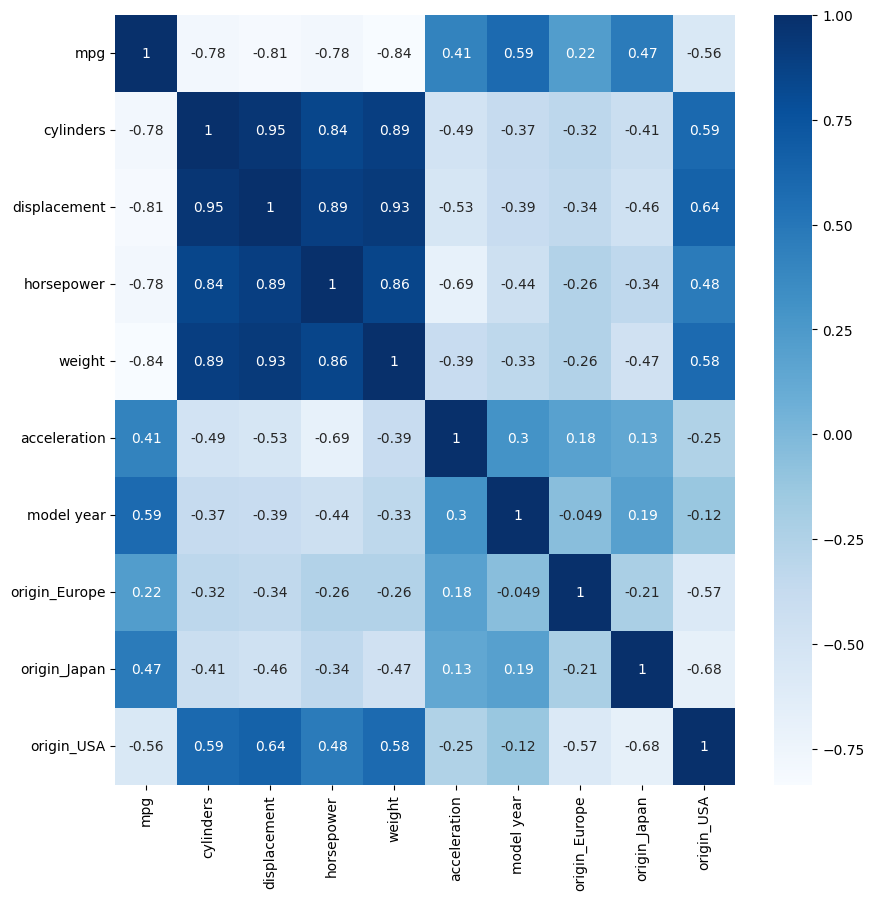

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='Blues');

*Aquí se ve claramente ese cuadrado de altas correlaciones y alguna que otra curiosidad (como esa correlación negativa entre ser de USA y el consumo)*

### Ejercicio 6 

Independientemente de lo que hayas encontrado en el análisis anterior, vamos a utilizar todas las features y antes las vamos a escalar. Estandardiza train y test.

In [21]:
scaler = StandardScaler()

train_set[features] = scaler.fit_transform(train_set[features])
test_set[features] = scaler.transform(test_set[features])

In [22]:
train_set.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_Europe,origin_Japan,origin_USA
count,313.000000,3.130000e+02,3.130000e+02,3.130000e+02,3.130000e+02,3.130000e+02,3.130000e+02,3.130000e+02,3.130000e+02,3.130000e+02
mean,23.599361,1.475568e-16,3.972683e-17,-1.475568e-16,2.553868e-16,5.646885e-16,-1.801896e-15,-1.418815e-17,-4.823972e-17,1.177617e-16
std,7.956255,1.001601e+00,1.001601e+00,1.001601e+00,1.001601e+00,1.001601e+00,1.001601e+00,1.001601e+00,1.001601e+00,1.001601e+00
min,9.000000,-1.462206e+00,-1.211552e+00,-1.532979e+00,-1.635082e+00,-2.681524e+00,-1.712775e+00,-4.255961e-01,-5.019960e-01,-1.349007e+00
25%,17.000000,-8.731837e-01,-8.737161e-01,-7.481006e-01,-8.956112e-01,-7.265654e-01,-8.850368e-01,-4.255961e-01,-5.019960e-01,-1.349007e+00
50%,23.000000,-8.731837e-01,-4.297035e-01,-2.510107e-01,-1.561399e-01,-1.567146e-02,-5.729820e-02,-4.255961e-01,-5.019960e-01,7.412860e-01
75%,30.000000,1.482907e+00,1.027816e+00,6.385185e-01,7.845723e-01,6.241331e-01,7.704404e-01,-4.255961e-01,-5.019960e-01,7.412860e-01
max,46.600000,1.482907e+00,2.504640e+00,3.280944e+00,2.564781e+00,3.289986e+00,1.598179e+00,2.349645e+00,1.992048e+00,7.412860e-01


## El modelo

### Ejercicio 7: Construye el modelo con Keras

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Es decir una MLP con dos capas ocultas.

Por tanto, tendrá tres capas:
- Una inicial con activación relu (usa el argumento `input_shape` para darle el número de features). 
- Otra hidden layer con activación relu.
- Y la de salida de regresión, que se compondrá de una única neurona. 

Pon las neuronas que consideres interesantes para las dos primeras capas (NOTA: En este caso partimos de pocas features, por lo que puede ser interesante poner 2 o 3 veces como mínimo el número de features para poder obtener unas pseudofeatures que intenten capturar las interrelaciones.)

Otros datos:

Para el compile utiliza un `loss='mse'`.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

Utiliza una aproximación en prisma (mismo numero de unidades en las capas ocultas)

In [23]:
# 3 veces el número de features será el número de neuronas
factor_expansion = 3
num_units = len(features) * factor_expansion
print('Neuronas por capa:', num_units)

Neuronas por capa: 27


*Utilizaré los dos métodos secuenciales (y no "Funcitonal API"), porque así lo pide el enunciado.*

In [24]:
# Método 1: Construcción apilando capas
model_add =  keras.models.Sequential()

# Define implicitamente la capa de entrada
model_add.add(keras.layers.Dense(num_units, activation='relu', input_shape=[len(features)]))
model_add.add(keras.layers.Dense(num_units, activation='relu'))
model_add.add(keras.layers.Dense(1))

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


*Me parece interesante el Warning:*

UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. super().__init__(activity_regularizer=activity_regularizer, **kwargs)

Voy a corregirlo. Ambos métodos son funcionalmente equivalentes, pero la versión con Input explícito proporciona más flexibilidad si es necesaria.

In [25]:
# Método 1 REVISADO: Construcción apilando capas + Input Layer
model_add_rev =  keras.models.Sequential()

model_add_rev.add(keras.layers.Input(shape=[len(features)]))
model_add_rev.add(keras.layers.Dense(num_units, activation='relu'))
model_add_rev.add(keras.layers.Dense(num_units, activation='relu'))
model_add_rev.add(keras.layers.Dense(1))

In [26]:
# Método 2: Contrucción con listas (secuencia de capas)
capas = [
    # Define implicitamente la capa de entrada
    keras.layers.Dense(num_units, activation='relu', input_shape=[len(features)]),
    keras.layers.Dense(num_units, activation='relu'),
    keras.layers.Dense(1)
]

model = keras.models.Sequential(capas)


*Podemos ver los pesos de las capas sin entrenar, porque los inicializa "aleatoriamente". Los bias los inicializan a 0.*

In [27]:
model.layers

[<Dense name=dense_6, built=True>,
 <Dense name=dense_7, built=True>,
 <Dense name=dense_8, built=True>]

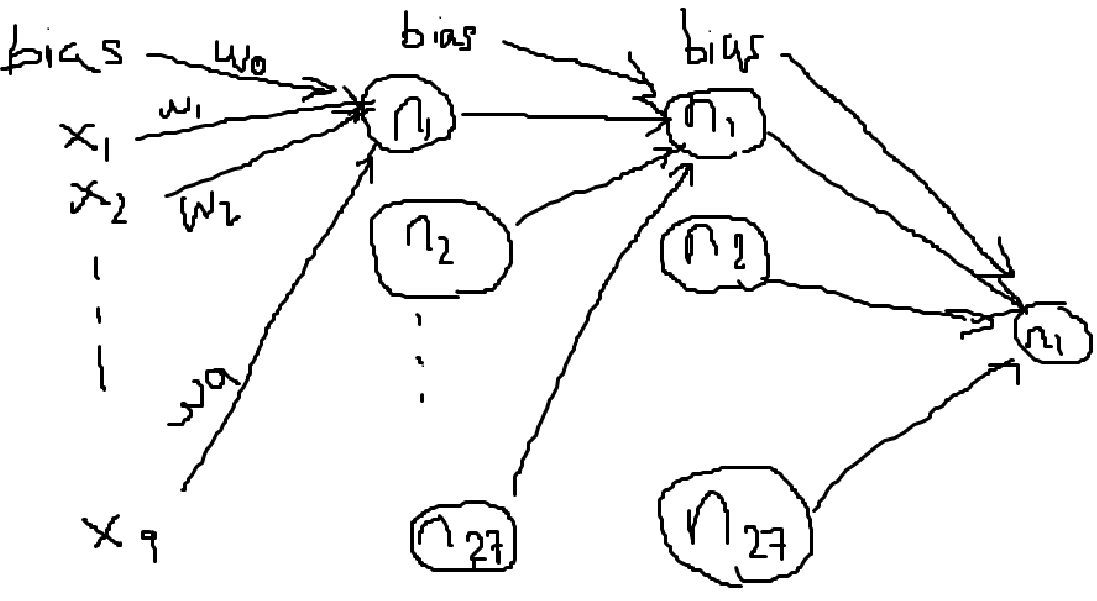

In [28]:
for i in range(3):
    weights, biases = model.layers[i].get_weights()
    print('Capa:', i)
    print(weights.shape)
    print(biases.shape)
    print('')

Capa: 0
(9, 27)
(27,)

Capa: 1
(27, 27)
(27,)

Capa: 2
(27, 1)
(1,)



In [29]:
weights, biases = model.layers[0].get_weights()
print(weights[0])
print(biases)

[-0.02693006 -0.08221188  0.27389234 -0.05446693  0.24053657 -0.2799589
 -0.31367704 -0.21703511 -0.19272332 -0.33251682  0.10901856  0.03933772
 -0.13489291 -0.38699397 -0.01666123 -0.20711298 -0.23261245  0.15148252
 -0.30911607 -0.0387468  -0.2252395   0.3307041  -0.17860134 -0.02357846
 -0.2898893  -0.3286841  -0.04265758]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


*Como los pesos ya se han inicializado se podría hacer ya una predicción... pero sería horrible. Primero hay que inicializar el modelo.*

*Establecemos la configuración de ejecución: compile.*

In [30]:
# Inicializador
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

### Ejercicio 8

Inspecciona el modelo usando el método `.summary` para imprimir una descripción simple del modelo

In [31]:
# La primera hidden layer tiene 9 + 1(bias) entradas x 27 salidas--> 270 parámetros
model_add_rev.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 27)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 27)             │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054 (4.12 KB)

 Trainable params: 1,054 (4.12 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# La primera hidden layer tiene 9 + 1(bias) entradas x 27 salidas--> 270 parámetros
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 27)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054 (4.12 KB)

 Trainable params: 1,054 (4.12 KB)

 Non-trainable params: 0 (0.00 B)

*Obviamente el resultado es el mismo en ambos casos.*

*Tenemos 1054 parámetros que entrenar:*  
*1a capa: 27 unidades * (9 + 1) features de entrada más el bias = 270 pesos*  
*2a capa: 27 unidades * (27 + 1) salidas de la capa anterior más el bias = 756 pesos*  
*Capa de salida: 1 unidad * (27 + 1) salidas de la capa anterior más el bias = 28 pesos*

*El tipo de modelo es como lo he dibujado con paint arriba.*


### Ejercicio 9 Entrenar el modelo

Entrena el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

In [33]:
# Split X, y
X_train = train_set.drop(columns=target)
y_train = train_set[target]

X_test = test_set.drop(columns=target)
y_test = test_set[target]

In [34]:
# Solo para saber cuantos batchs vamos a tener --> 5
# train_set.shape = (313, 10)
muestras = train_set.shape[0]
batch_size = 64
muestras / batch_size

4.890625

In [35]:
# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=1_000,
    validation_split=0.2
)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 588.2889 - mae: 22.9250 - mse: 588.2889 - val_loss: 669.4581 - val_mae: 24.7046 - val_mse: 669.4581
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 578.7913 - mae: 22.8073 - mse: 578.7913 - val_loss: 657.0547 - val_mae: 24.4584 - val_mse: 657.0547
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 558.3857 - mae: 22.3692 - mse: 558.3857 - val_loss: 646.0672 - val_mae: 24.2397 - val_mse: 646.0672
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 559.5903 - mae: 22.2874 - mse: 559.5903 - val_loss: 635.3452 - val_mae: 24.0254 - val_mse: 635.3452
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 572.7531 - mae: 22.5445 - mse: 572.7531 - val_loss: 624.7602 - val_mae: 23.8124 - val_mse: 624.7602
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 532.2690 - mae: 21.7909 - mse: 532.2690 - val_loss: 613.8325 - val_mae: 23.5914 - val_mse: 613.8325
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

*En realidad gracias al "verbose" y las lineas informativas de progreso he visto que esto ha convergido rápido (hay que fijaserse en "loss"), y probablemente podría haberse parado mucho antes de la 1000 épocas.*

*Reentrenar ahora el modelo implicaría seguir desde donde se ha quedado. NO empezar de nuevo.*

### Ejercicio 10

Visualiza el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`. Muestra la evolución del error en train y validation por un lado, y la evolución de la pérdida (loss), también train contra validation, en otra.

In [36]:
# Histórico del entrenamiento gracias a que lo he guardado en una variable "history"
print(history.params)
print(history.epoch)
print(history.history)

{'verbose': 'auto', 'epochs': 1000, 'steps': 4}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 2

In [37]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

*Recordar que `loss='mse'`, así que estos valores en la gráfica son la misma curva.*

*Podemos querer ver los últimos valores*

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,4.718171,1.518596,4.718171,6.081942,1.835085,6.081942,995
996,4.696990,1.507324,4.696990,5.981822,1.811226,5.981822,996
997,4.677890,1.492489,4.677890,5.938974,1.807750,5.938974,997
998,4.827099,1.529492,4.827099,6.689635,1.879938,6.689635,998
999,4.719956,1.518507,4.719956,6.367190,1.852232,6.367190,999


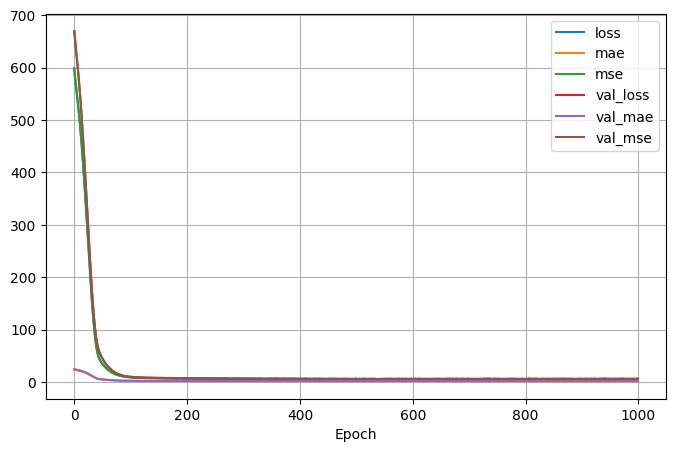

In [39]:
# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

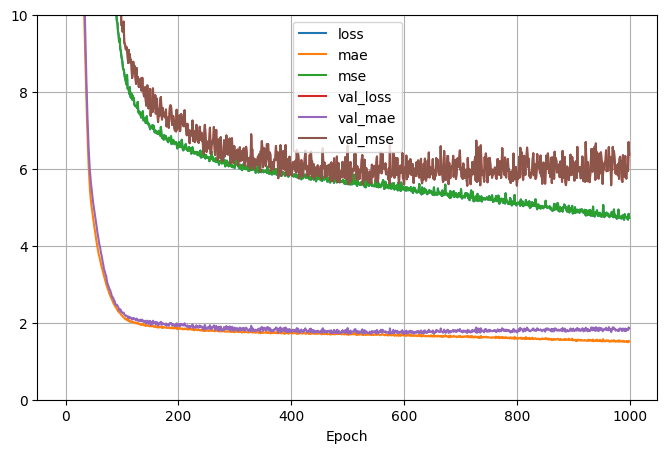

In [40]:
# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs haciendo un zoom
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.xlabel('Epoch')
plt.show()

*Alberto propone esta otra solución.*

In [41]:
def plot_history(history, error=True):
    """
    Plots the training and validation metrics from a Keras model's history object.

    This function visualizes the progression of training and validation metrics across epochs.
    If `error` is set to True, it plots the Mean Absolute Error (MAE) and Mean Square Error (MSE)
    for both the training and validation datasets. If `error` is set to False, it only plots the 
    training and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        A History object returned from the training process (`model.fit()`), which contains
        the recorded metrics for each epoch, such as loss, MAE, and MSE.
    
    error : bool, optional, default=True
        If True, the function will plot the MAE and MSE for both training and validation.
        If False, it will only plot the training and validation loss.

    Returns
    -------
    None
        This function does not return anything. It displays the plots for metrics.

    Example
    -------
    >>> history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    >>> plot_history(history, error=True)
    """
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    if error:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [MPG]')
        plt.plot(hist['epoch'], hist['mae'],
                label='Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        plt.ylim([0,5])
        plt.legend()

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [$MPG^2$]')
        plt.plot(hist['epoch'], hist['mse'],
                label='Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        plt.ylim([0,20])
        plt.legend()
        plt.show()

    else:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(hist['epoch'], hist['loss'],
                label='Train loss')
        plt.plot(hist['epoch'], hist['val_loss'],
                label = 'Val loss')
        plt.legend()
        plt.show()


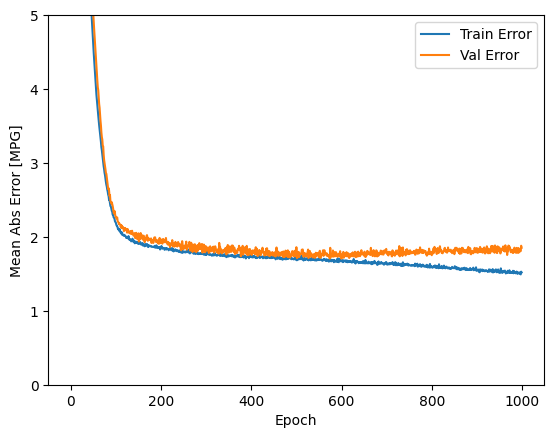

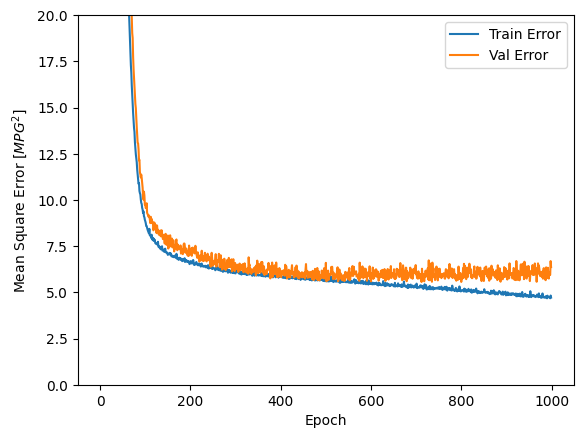

In [42]:
plot_history(history, error=True)

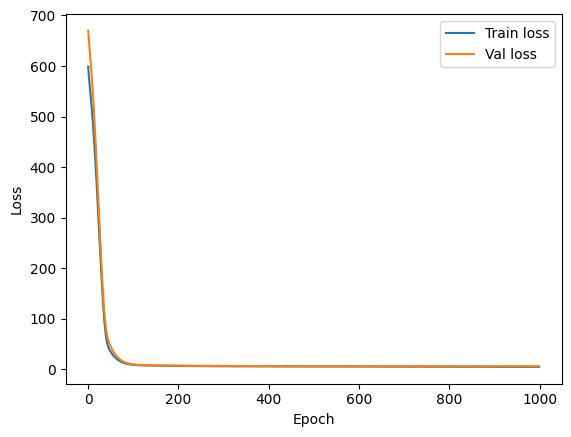

In [43]:
plot_history(history, error=False)

### Ejercicio 11

Comenta las gráficas anteriores.

*Estos gráficos muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas.*

*Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una **devolución de llamada de EarlyStopping** (un callback EarlyStopping) que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.*

### Ejercicio 12

Independientemente de lo comentado en 11, vamos a añadir un callback al entrenamiento. Para ello, construye el modelo otra vez y vuelve a compilarlo (si no lo haces, como ya sabes comenzará el entrenamiento donde lo dejó y no nos valdrá el callback para nada). Entrena el modelo con los mismos hiperparámetros del ejercicio 10 y pinta la gráfica de evolución de los errores e interprétalo (obten el MAE medio una vez "estabilizado" el entrenamiento).  

Para el earlystopping utiliza un margen de 20 epochs.

In [44]:
# Contrucción con listas (secuencia de capas)
model = keras.models.Sequential([
    keras.layers.Dense(num_units, activation='relu', input_shape=[len(features)]),
    keras.layers.Dense(num_units, activation='relu'),
    keras.layers.Dense(1)
])

# Inicializador
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Callback: EarlyStopping
cb_earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
    )

# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=1_000,
    verbose='auto',
    callbacks=[cb_earlystopping],
    validation_split=0.2
)

Epoch 1/1000


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 587.1232 - mae: 22.6823 - mse: 587.1232 - val_loss: 659.5638 - val_mae: 24.3475 - val_mse: 659.5638
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 591.0774 - mae: 22.7231 - mse: 591.0774 - val_loss: 646.4026 - val_mae: 24.0821 - val_mse: 646.4026
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 550.8605 - mae: 21.9210 - mse: 550.8605 - val_loss: 634.3182 - val_mae: 23.8351 - val_mse: 634.3182
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 563.9259 - mae: 22.2004 - mse: 563.9259 - val_loss: 622.3474 - val_mae: 23.5863 - val_mse: 622.3474
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 545.9353 - mae: 21.7519 - mse: 545.9353 - val_loss: 609.7889 - val_mae: 23.3251 - val_mse: 609.7889
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 517.3029 - mae: 21.1798 - mse: 517.3029 - val_loss: 596.5973 - val_mae: 23.0487 - val_mse: 596.5973
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5

Interpreta el gráfico

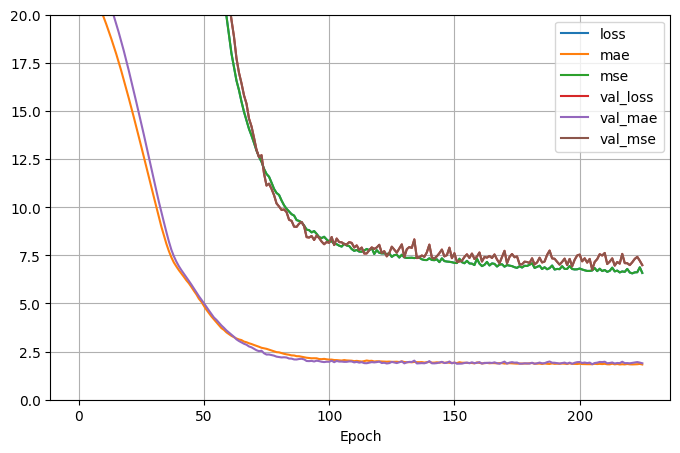

In [45]:
# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs haciendo un zoom
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 20)
plt.xlabel('Epoch')
plt.show()

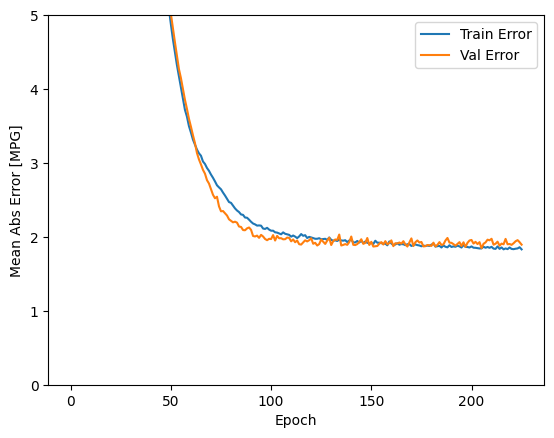

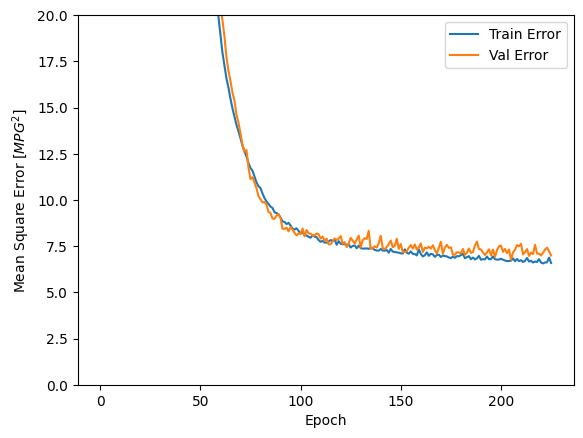

In [46]:
plot_history(history, error=True)

*Está claro que no merecía la pena entrenar con tantas épocas, antes de las 300 hemos terminado y que sobre las 150 epocas se estabiliza. Notar también que cada ejecución puede ser distinta.*

<Axes: >

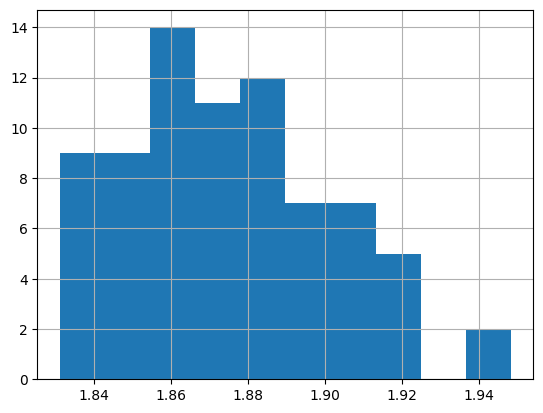

In [55]:
stable_epoch = 150
history_df = pd.DataFrame(history.history)
history_df[stable_epoch:].mae.hist()

In [63]:
# Valor medio del MAE a partir de una época estable.
print('Valor medio de MAE:', history_df[stable_epoch:].mae.mean(), 'MPG')

Valor medio de MAE: 1.875318141360032 MPG


### Ejercicio 13

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [57]:
# Evaluar las métricas
loss, mae, mse = model.evaluate(X_test, y_test, verbose='auto')
print('Testing Set MAE: {:.2f} MPG'.format(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9508 - mae: 1.7937 - mse: 5.9508 
Testing Set MAE: 1.86 MPG


In [58]:
# MAPE medio
mape = mae/y_test.mean() * 100
mape

8.153965680380642

*Un error medio del 8.2 %.*

### Ejercicio 14

Dibuja en un scatter plot las predicciones de test vs sus true labels.

In [59]:
model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[26.604467],
       [23.174238],
       [35.72715 ],
       [26.187944],
       [29.518452],
       [30.422016],
       [12.402927],
       [30.933517],
       [18.726358],
       [32.71408 ],
       [14.639042],
       [20.4678  ],
       [17.273888],
       [29.353336],
       [18.872993],
       [29.594326],
       [18.546783],
       [34.663963],
       [28.218271],
       [29.993727],
       [19.757038],
       [44.335415],
       [37.287373],
       [16.234924],
       [30.201736],
       [25.13094 ],
       [20.208519],
       [16.132502],
       [31.95423 ],
       [23.308992],
       [14.357917],
       [21.217352],
       [19.984804],
       [33.3992  ],
       [13.67747 ],
       [38.496044],
       [13.864453],
       [25.280216],
       [12.437171],
       [11.610618],
       [14.175189],
       [28.216217],
       [37.80441 ],
       [26.720476],
       [14.412304],
       [13.778848],
       [16.862125],
       [33.881275],
       [22.45317 ],
       [31.215763],


In [60]:
model.predict(X_test).shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(79, 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


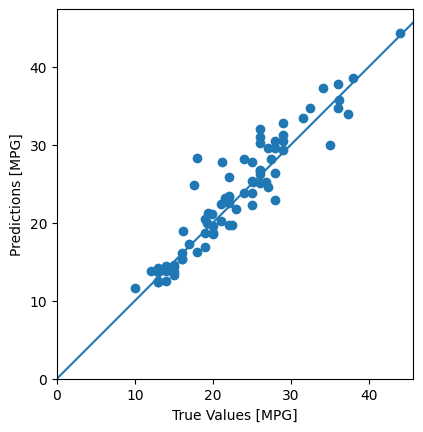

In [69]:
# Habrá que aplanar más adelante porque devuelve un array de dos dimensiones
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])


*Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.*


Text(0, 0.5, 'Count')

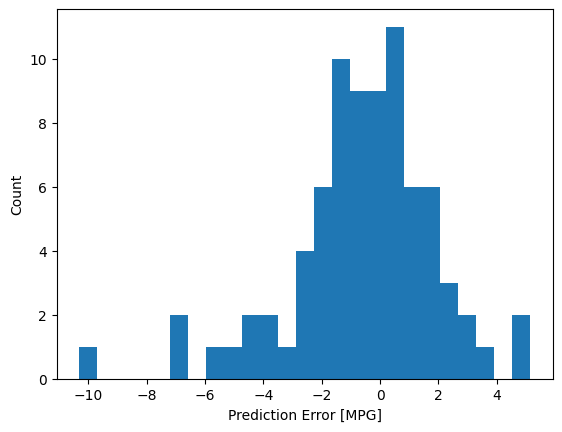

In [71]:
# Aplanar con flatten() porque devuelve un array de dos dimensiones
error = y_test - y_pred.flatten() 

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")